# Auotencoders

![](https://blog.keras.io/img/ae/autoencoder_schema.jpg)

"Autoencoding" is a data compression algorithm where the compression and decompression functions are  data-specific, lossy, and learned automatically from examples rather than engineered by a human. 

Additionally, in almost all contexts where the term "autoencoder" is used, the compression and decompression functions are implemented with neural networks.

1. Autoencoders are data-specific, which means that they will only be able to compress data similar to what they have been trained on. This is different from, say, the MPEG-2 Audio Layer III (MP3) compression algorithm, which only holds assumptions about "sound" in general, but not about specific types of sounds. An autoencoder trained on pictures of faces would do a rather poor job of compressing pictures of trees, because the features it would learn would be face-specific.

2. Autoencoders are lossy, which means that the decompressed outputs will be degraded compared to the original inputs (similar to MP3 or JPEG compression). This differs from lossless arithmetic compression.

3. Autoencoders are learned automatically from data examples, which is a useful property: it means that it is easy to train specialized instances of the algorithm that will perform well on a specific type of input. It doesn't require any new engineering, just appropriate training data.

To build an autoencoder, we need three things: an encoding function, a decoding function, and a distance function between the amount of information loss between the compressed representation of the data and the decompressed representation (i.e. a "loss" function). The encoder and decoder will be chosen to be parametric functions (typically neural networks), and to be differentiable with respect to the distance function, so the parameters of the encoding/decoding functions can be optimize to minimize the reconstruction loss, using Gradient Descent.

## Are they good at data compression?
Usually, not really. In picture compression for instance, it is pretty difficult to train an autoencoder that does a better job than a basic algorithm like JPEG, and typically the only way it can be achieved is by restricting yourself to a very specific type of picture (e.g. one for which JPEG does not do a good job). The fact that autoencoders are data-specific makes them generally impractical for real-world data compression problems: we can only use them on data that is similar to what they were trained on, and making them more general thus requires lots of training data. But future advances might change this, who knows.

## What are autoencoders good for?
Today two interesting practical applications of autoencoders are data denoising, and dimensionality reduction for data visualization. With appropriate dimensionality and sparsity constraints, autoencoders can learn data projections that are more interesting than PCA or other basic techniques.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from tensorflow.keras import layers, losses, callbacks, utils
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model, Sequential

# Basic Autoencoder

In [2]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

4423680/4422102 [==============================] - 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)


In [3]:
class config():
    INPUT_SHAPE = (28, 28)
    HIDDEN_DIMS = [244]
    LATENT_DIM = 64
    
    MAX_EPOCHS = 100
    

In [4]:
class BasicAutoencoder(Model):
  def __init__(self, input_shape, hidden_dims, latent_dim):
    super(BasicAutoencoder, self).__init__()
    self.latent_dim = latent_dim   
    
    encoder_layers = [layers.Dense(hid_dim, activation='relu') for hid_dim in hidden_dims]
    encoder_layers.append(layers.Dense(latent_dim, activation='relu'))
    encoder_layers.insert(0, layers.Flatten())
    
    self.encoder = Sequential(encoder_layers)
    
    
    decoder_layers = [layers.Dense(hid_dim, activation='relu') for hid_dim in hidden_dims[::-1]]
    decoder_layers.append(layers.Dense(input_shape[0]*input_shape[1], activation='sigmoid'))
    decoder_layers.append(layers.Reshape(input_shape))
    
    self.decoder = Sequential(decoder_layers)

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = BasicAutoencoder(config.INPUT_SHAPE, config.HIDDEN_DIMS, config.LATENT_DIM)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [5]:
es = callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.0001, patience=7, verbose=1, mode='min', baseline=None,
    restore_best_weights=True
)

rlp = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, mode='min', verbose=1
)

history =  autoencoder.fit(
    x_train, x_train, validation_data=(x_test, x_test), shuffle=True,
    callbacks=[es, rlp], epochs=config.MAX_EPOCHS
)

Epoch 1/100
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0202 - val_loss: 0.0130
Epoch 2/100
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0117 - val_loss: 0.0108
Epoch 3/100
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0102 - val_loss: 0.0099
Epoch 4/100
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0094 - val_loss: 0.0093
Epoch 5/100
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0090 - val_loss: 0.0089
Epoch 6/100
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0086 - val_loss: 0.0087
Epoch 7/100
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0084 - val_loss: 0.0085
Epoch 8/100
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0082 - val_loss: 0.0082
Epoch 9/100
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0081 - val_loss: 0.0083
Epoch 10/100
1875/1875 [==============================] - 3s 2ms/step - l

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 244)               191540    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                15680     
Total params: 207,220
Trainable params: 207,220
Non-trainable params: 0
_________________________________________________________________


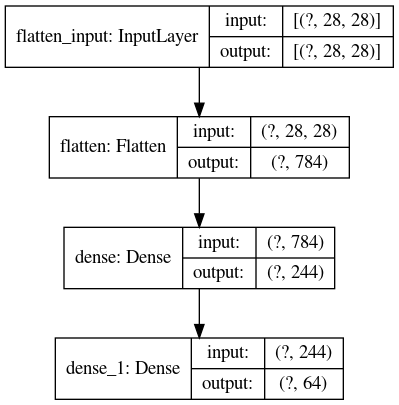

In [6]:
autoencoder.encoder.summary()
utils.plot_model(autoencoder.encoder, show_shapes=True)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 244)               15860     
_________________________________________________________________
dense_3 (Dense)              (None, 784)               192080    
_________________________________________________________________
reshape (Reshape)            (None, 28, 28)            0         
Total params: 207,940
Trainable params: 207,940
Non-trainable params: 0
_________________________________________________________________


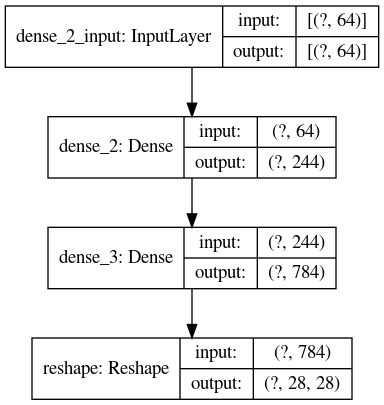

In [7]:
autoencoder.decoder.summary()
utils.plot_model(autoencoder.decoder, show_shapes=True)

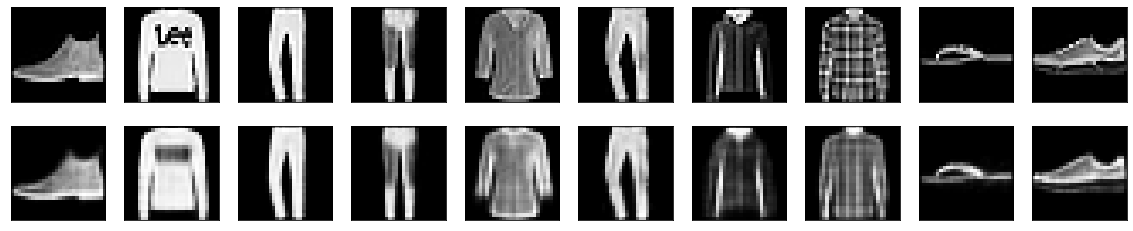

In [8]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

fig, ax = plt.subplots(2, 10, figsize=(20, 4))
for i in range(10):
  ax[0][i].imshow(x_test[i], cmap='gray')
  ax[0][i].get_xaxis().set_visible(False)
  ax[0][i].get_yaxis().set_visible(False)

  ax[1][i].imshow(decoded_imgs[i], cmap='gray')
  ax[1][i].get_xaxis().set_visible(False)
  ax[1][i].get_yaxis().set_visible(False)

# Denoising Autoencoder

We will create a noisy version of the Fashion MNIST dataset by applying random noise to each image. We will then train an autoencoder using the noisy image as input, and the original image as the target.

In [9]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

print(x_train.shape)

(60000, 28, 28, 1)


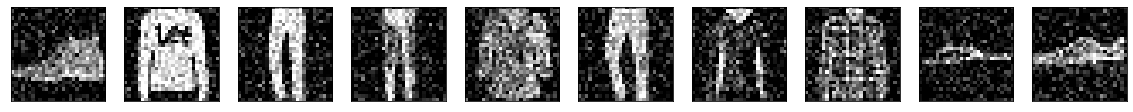

In [10]:
fig, ax = plt.subplots(1, 10, figsize=(20, 4))
for i in range(10):
  ax[i].imshow(tf.squeeze(x_test_noisy[i]), cmap='gray')
  ax[i].get_xaxis().set_visible(False)
  ax[i].get_yaxis().set_visible(False)

In [11]:
class DenoisingAutoencoder(Model):
  def __init__(self):
    super(DenoisingAutoencoder, self).__init__()
    self.encoder = tf.keras.Sequential([
        layers.Input(shape=(28, 28, 1)), 
        layers.Conv2D(16, (3,3), activation='relu', padding='same', strides=1),
        layers.MaxPooling2D((2, 2), padding='same'),
        layers.Conv2D(8, (3,3), activation='relu', padding='same', strides=1),
        layers.MaxPooling2D((2, 2), padding='same'),
    ])

    self.decoder = tf.keras.Sequential([
        layers.Conv2DTranspose(8, kernel_size=3, strides=1, activation='relu', padding='same'),
        layers.UpSampling2D((2, 2)),
        layers.Conv2DTranspose(16, kernel_size=3, strides=1, activation='relu', padding='same'),
        layers.UpSampling2D((2, 2)),
        layers.Conv2D(1, kernel_size=(3,3), activation='sigmoid', padding='same')
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = DenoisingAutoencoder()
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [12]:
es = callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.0001, patience=7, verbose=1, mode='min', baseline=None,
    restore_best_weights=True
)

rlp = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, mode='min', verbose=1
)

history =  autoencoder.fit(
    x_train_noisy, x_train, validation_data=(x_test_noisy, x_test), shuffle=True,
    callbacks=[es, rlp], epochs=config.MAX_EPOCHS
)

Epoch 1/100
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0189 - val_loss: 0.0124
Epoch 2/100
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0115 - val_loss: 0.0109
Epoch 3/100
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0104 - val_loss: 0.0101
Epoch 4/100
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0099 - val_loss: 0.0097
Epoch 5/100
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0095 - val_loss: 0.0094
Epoch 6/100
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0093 - val_loss: 0.0092
Epoch 7/100
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0091 - val_loss: 0.0091
Epoch 8/100
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0090 - val_loss: 0.0090
Epoch 9/100
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0089 - val_loss: 0.0090
Epoch 10/100
1875/1875 [==============================] - 5s 3ms/step - l

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


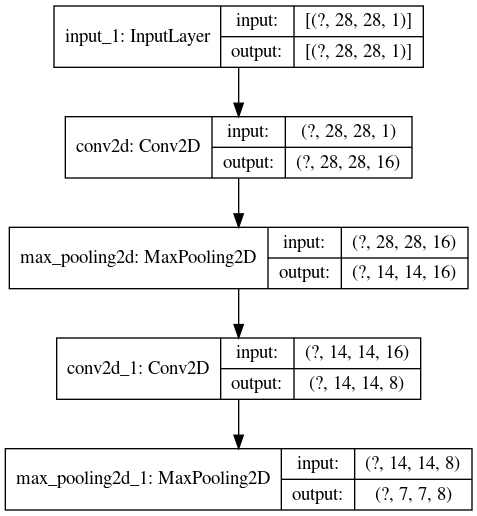

In [13]:
autoencoder.encoder.summary()
utils.plot_model(autoencoder.encoder, show_shapes=True)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose (Conv2DTran (None, 7, 7, 8)           584       
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 16)        1168      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 1)         145       
Total params: 1,897
Trainable params: 1,897
Non-trainable params: 0
_________________________________________________________________


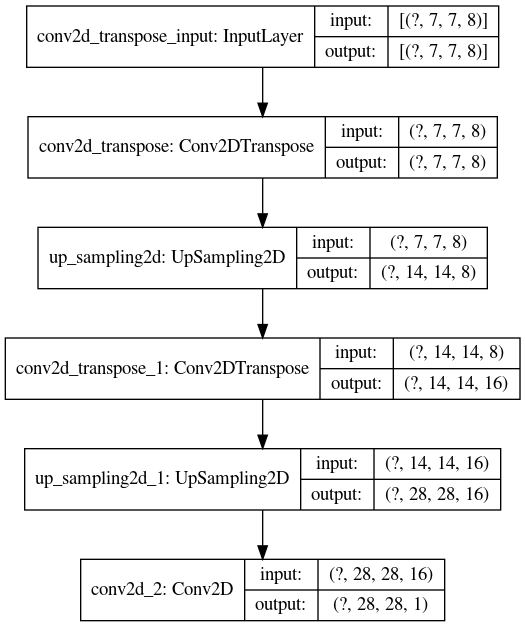

In [14]:
autoencoder.decoder.summary()
utils.plot_model(autoencoder.decoder, show_shapes=True)

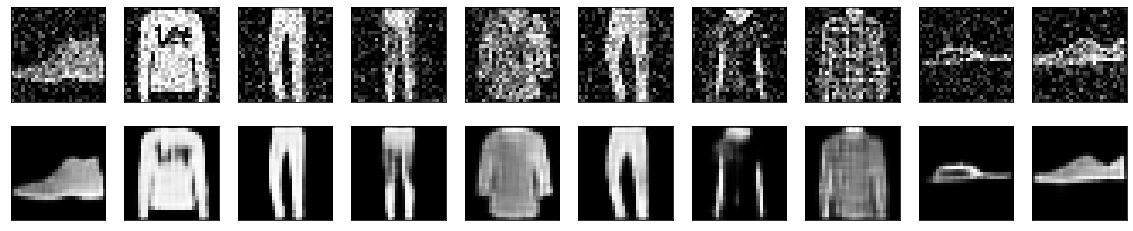

In [15]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

fig, ax = plt.subplots(2, 10, figsize=(20, 4))
for i in range(10):
  ax[0][i].imshow(tf.squeeze(x_test_noisy[i]), cmap='gray')
  ax[0][i].get_xaxis().set_visible(False)
  ax[0][i].get_yaxis().set_visible(False)

  ax[1][i].imshow(tf.squeeze(decoded_imgs[i]), cmap='gray')
  ax[1][i].get_xaxis().set_visible(False)
  ax[1][i].get_yaxis().set_visible(False)

# Anomaly Detector

We will train an autoencoder to detect anomalies on the ECG5000 dataset. This dataset contains 5,000 Electrocardiograms, each with 140 data points. We will use a simplified version of the dataset, where each example has been labeled either 0 (corresponding to an abnormal rhythm), or 1 (corresponding to a normal rhythm).

How will we detect anomalies using an autoencoder? Recall that an autoencoder is trained to minimize reconstruction error. You will train an autoencoder on the normal rhythms only, then use it to reconstruct all the data. Our hypothesis is that the abnormal rhythms will have higher reconstruction error. We will then classify a rhythm as an anomaly if the reconstruction error surpasses a fixed threshold.

In [16]:
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818287,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490658,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [17]:
labels = raw_data[:, -1]
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.1, random_state=19)

**Normalize the Data**

In [18]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

We will train the autoencoder using only the normal rhythms, which are labeled in this dataset as 1. Separate the normal rhythms from the abnormal rhythms.

In [19]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

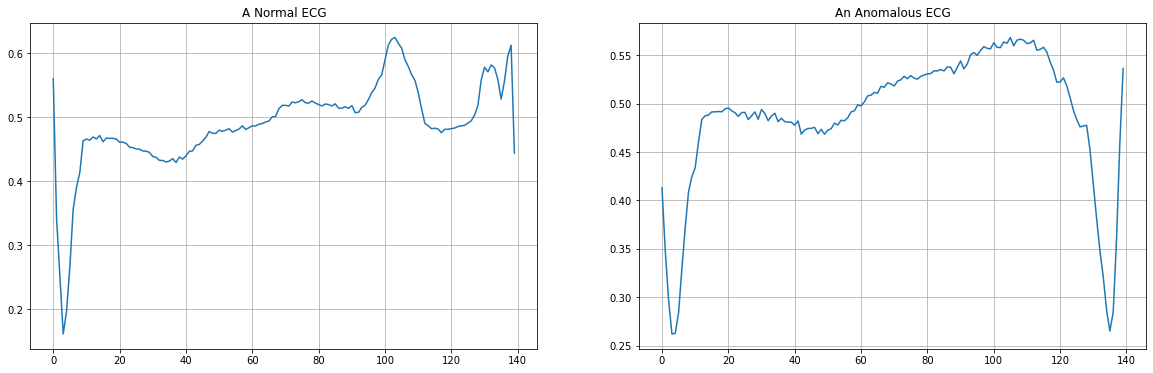

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

ax[0].grid()
ax[0].plot(np.arange(140), normal_train_data[0])
ax[0].set_title("A Normal ECG")

ax[1].grid()
ax[1].plot(np.arange(140), anomalous_train_data[0])
ax[1].set_title("An Anomalous ECG");

In [21]:
class config():
    INPUT_UNITS = 140
    HIDDEN_UNITS = [32, 16, 8]
    
    MAX_EPOCHS = 100
    BATCH_SIZE = 512
    

In [22]:
class AnomalyDetector(Model):
  def __init__(self, input_units, hidden_units):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([layers.Dense(unit, activation="relu") for unit in hidden_units])

    decoder_layers = [layers.Dense(unit, activation="relu") for unit in hidden_units[:-1:-1]] 
    decoder_layers.append(layers.Dense(input_units, activation="sigmoid"))
    
    self.decoder = tf.keras.Sequential(decoder_layers)

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector(config.INPUT_UNITS, config.HIDDEN_UNITS)
autoencoder.compile(optimizer='adam', loss='mean_absolute_error')

In [23]:
es = callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.0001, patience=7, verbose=1, mode='min', baseline=None,
    restore_best_weights=True
)

rlp = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, mode='min', verbose=1
)

history =  autoencoder.fit(
    normal_train_data, normal_train_data, validation_data=(test_data, test_data), shuffle=True,
    callbacks=[es, rlp], epochs=config.MAX_EPOCHS, batch_size=config.BATCH_SIZE
)

Epoch 1/100
6/6 [==============================] - 0s 17ms/step - loss: 0.0540 - val_loss: 0.0450
Epoch 2/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0448 - val_loss: 0.0432
Epoch 3/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0430 - val_loss: 0.0421
Epoch 4/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0413 - val_loss: 0.0411
Epoch 5/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0397 - val_loss: 0.0402
Epoch 6/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0381 - val_loss: 0.0393
Epoch 7/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0366 - val_loss: 0.0385
Epoch 8/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0351 - val_loss: 0.0378
Epoch 9/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0338 - val_loss: 0.0371
Epoch 10/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0325 - val_loss: 0.0366
Epoch 11/100
6/6 [==========

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 32)                4512      
_________________________________________________________________
dense_5 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
Total params: 5,176
Trainable params: 5,176
Non-trainable params: 0
_________________________________________________________________


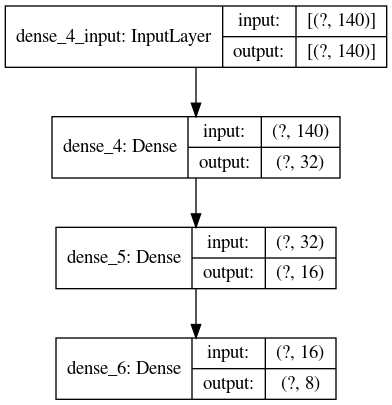

In [24]:
autoencoder.encoder.summary()
utils.plot_model(autoencoder.encoder, show_shapes=True)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 140)               1260      
Total params: 1,260
Trainable params: 1,260
Non-trainable params: 0
_________________________________________________________________


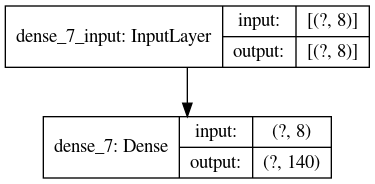

In [25]:
autoencoder.decoder.summary()
utils.plot_model(autoencoder.decoder, show_shapes=True)

We will soon classify an ECG as anomalous if the reconstruction error is greater than one standard deviation from the normal training examples. First, let's plot a normal ECG from the training set, the reconstruction after it's encoded and decoded by the autoencoder, and the reconstruction error.

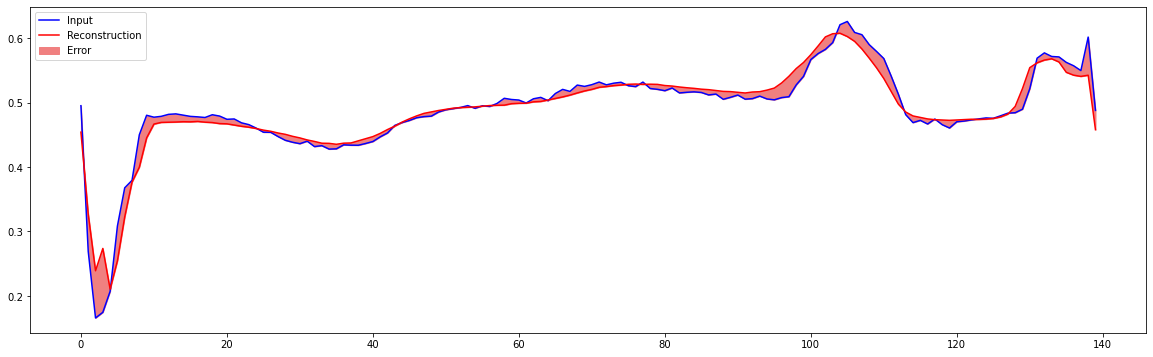

In [26]:
encoded_signals = autoencoder.encoder(normal_test_data).numpy()
decoded_signals = autoencoder.decoder(encoded_signals).numpy()

plt.figure(figsize=(20, 6))
plt.plot(normal_test_data[0],'b')
plt.plot(decoded_signals[0],'r')
plt.fill_between(np.arange(140), decoded_signals[0],  normal_test_data[0], color='lightcoral' )
plt.legend(labels=["Input", "Reconstruction", "Error"]);

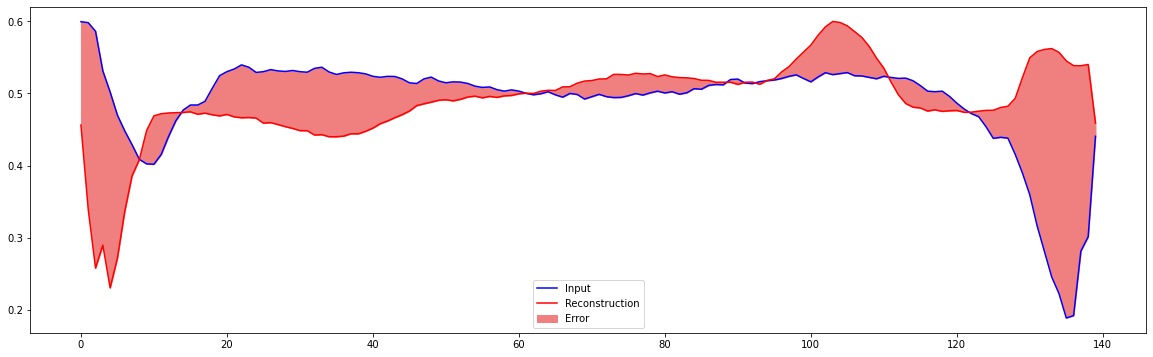

In [27]:
encoded_signals = autoencoder.encoder(anomalous_test_data).numpy()
decoded_signals = autoencoder.decoder(encoded_signals).numpy()

plt.figure(figsize=(20, 6))
plt.plot(anomalous_test_data[0],'b')
plt.plot(decoded_signals[0],'r')
plt.fill_between(np.arange(140), decoded_signals[0], anomalous_test_data[0], color='lightcoral' )
plt.legend(labels=["Input", "Reconstruction", "Error"]);

We will now calculate the mean average error for normal examples from the training set, then classify future examples as anomalous if the reconstruction error is higher than one standard deviation from the training set.

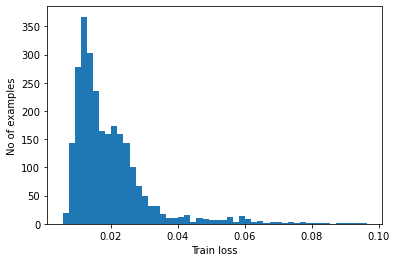

In [28]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples");

In [29]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.031050637


If we examine the recontruction error for the anomalous examples in the test set, we'll notice most have greater reconstruction error than the threshold. By varing the threshold, we can adjust the precision and recall of our classifier.

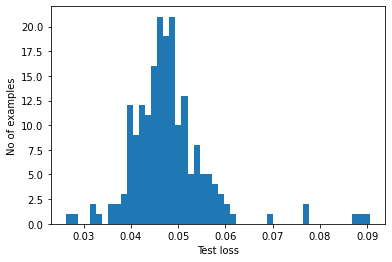

In [30]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss, bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples");

In [31]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print(f"Accuracy = {accuracy_score(labels, preds)}")
  print(f"Precision = {precision_score(labels, preds)}")
  print(f"Recall = {recall_score(labels, preds)}")

In [32]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.928
Precision = 0.9926739926739927
Recall = 0.8885245901639345


# Recurrent Autoencoder

The Recurrent network can be organized into an Encoder-Decoder architecture, that allows the model to be used to both support variable length input sequences and to predict or output variable length output sequences.

This architecture is the basis for many advances in complex sequence prediction problems such as speech recognition and text translation.

In this architecture, an encoder Recurrent model reads the input sequence step-by-step. After reading in the entire input sequence, the hidden state or output of this model represents an internal learned representation of the entire input sequence as a fixed-length vector. This vector is then provided as an input to the decoder model that interprets it as each step in the output sequence is generated.

In [33]:
class RecurrentAutoencoder(Model):
  def __init__(self):
    super(RecurrentAutoencoder, self).__init__()
    self.encoder = tf.keras.Sequential([
        layers.Reshape((140, 1)),
        layers.LSTM(64, input_shape=(140, 1), return_sequences=False)
    ])

    self.decoder = tf.keras.Sequential([
        layers.RepeatVector(140),
        layers.LSTM(64, return_sequences=True),
        layers.TimeDistributed(layers.Dense(1)),
        layers.Reshape((140,))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = RecurrentAutoencoder()
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [34]:
es = callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.0001, patience=7, verbose=1, mode='min', baseline=None,
    restore_best_weights=True
)

rlp = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, mode='min', verbose=1
)

history =  autoencoder.fit(
    normal_train_data, normal_train_data, validation_data=(normal_test_data, normal_test_data), shuffle=True,
    callbacks=[es, rlp], epochs=100
)

Epoch 1/100
82/82 [==============================] - 2s 19ms/step - loss: 0.0112 - val_loss: 0.0043
Epoch 2/100
82/82 [==============================] - 1s 12ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 3/100
82/82 [==============================] - 1s 12ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 4/100
82/82 [==============================] - 1s 12ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 5/100
82/82 [==============================] - 1s 12ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 6/100
82/82 [==============================] - 1s 14ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 7/100
82/82 [==============================] - 1s 12ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 8/100
82/82 [==============================] - 1s 12ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 9/100
82/82 [==============================] - 1s 12ms/step - loss: 0.0024 - val_loss: 0.0019
Epoch 10/100
82/82 [==============================] - 1s 12ms/step - loss: 0.0018 - val_loss: 0.0015

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 140, 1)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                16896     
Total params: 16,896
Trainable params: 16,896
Non-trainable params: 0
_________________________________________________________________


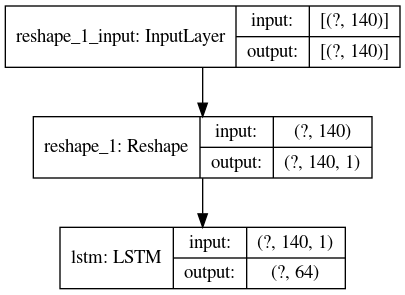

In [35]:
autoencoder.encoder.summary()
utils.plot_model(autoencoder.encoder, show_shapes=True)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
repeat_vector (RepeatVector) (None, 140, 64)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 140, 64)           33024     
_________________________________________________________________
time_distributed (TimeDistri (None, 140, 1)            65        
_________________________________________________________________
reshape_2 (Reshape)          (None, 140)               0         
Total params: 33,089
Trainable params: 33,089
Non-trainable params: 0
_________________________________________________________________


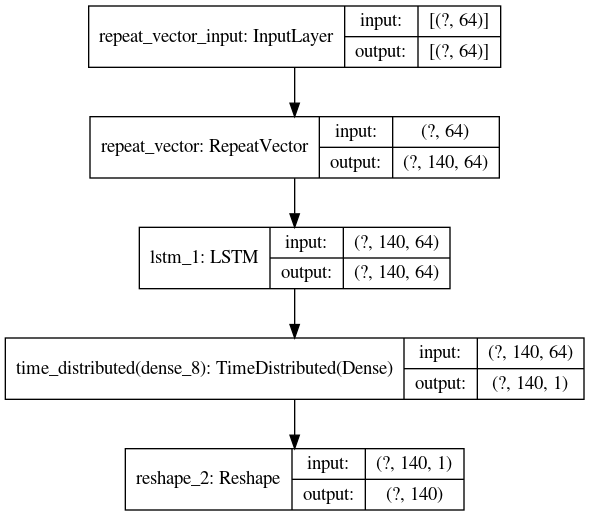

In [36]:
autoencoder.decoder.summary()
utils.plot_model(autoencoder.decoder, show_shapes=True)

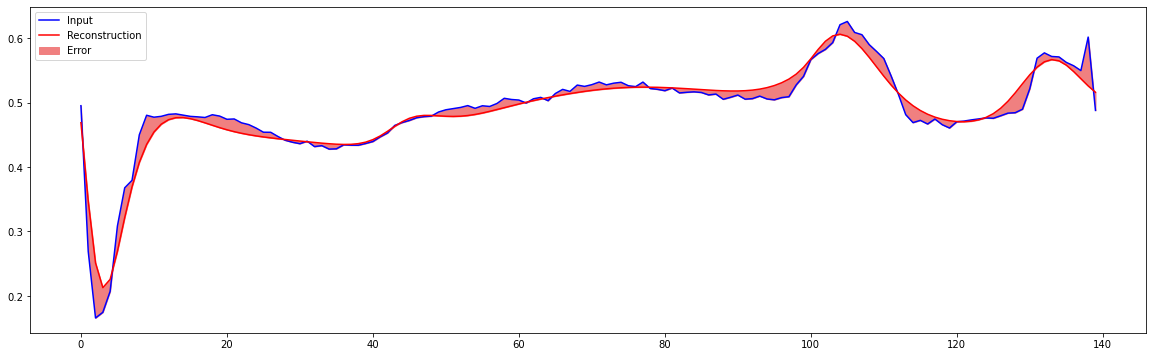

In [37]:
encoded_signals = autoencoder.encoder(normal_test_data).numpy()
decoded_signals = autoencoder.decoder(encoded_signals).numpy()

plt.figure(figsize=(20, 6))
plt.plot(normal_test_data[0],'b')
plt.plot(decoded_signals[0],'r')
plt.fill_between(np.arange(140), decoded_signals[0],  normal_test_data[0], color='lightcoral' )
plt.legend(labels=["Input", "Reconstruction", "Error"]);

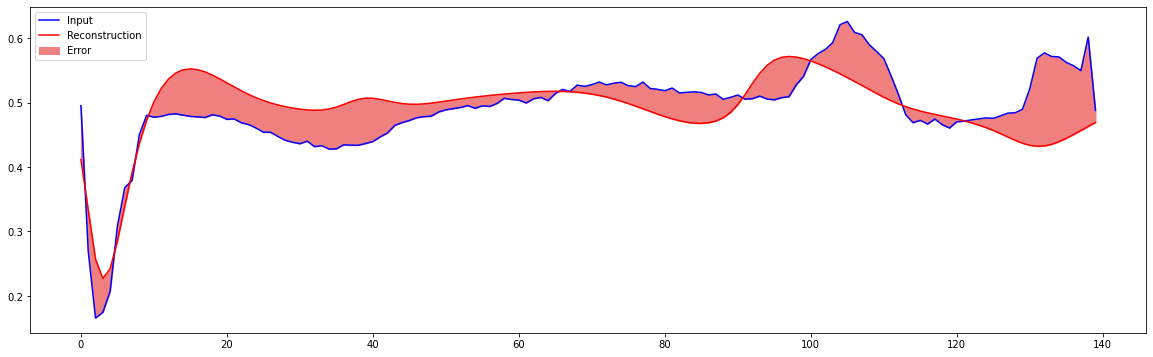

In [38]:
encoded_signals = autoencoder.encoder(anomalous_test_data).numpy()
decoded_signals = autoencoder.decoder(encoded_signals).numpy()

plt.figure(figsize=(20, 6))
plt.plot(normal_test_data[0],'b')
plt.plot(decoded_signals[0],'r')
plt.fill_between(np.arange(140), decoded_signals[0],  normal_test_data[0], color='lightcoral' )
plt.legend(labels=["Input", "Reconstruction", "Error"]);

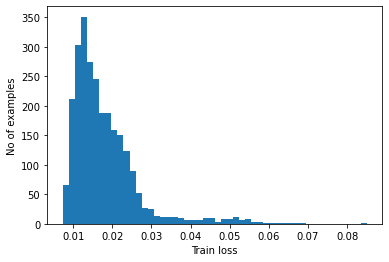

In [39]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples");

In [40]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.02664654


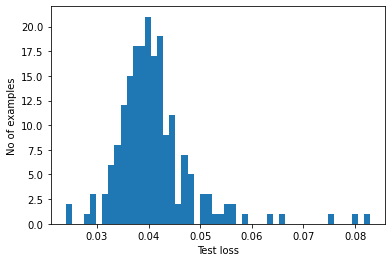

In [41]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss, bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples");

In [42]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.932
Precision = 0.9927272727272727
Recall = 0.8950819672131147
